### Mini project III - Word embedding

In [111]:
from khmernltk import word_tokenize
from collections import Counter
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.decomposition import PCA
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn.functional as F
import math

In [112]:
# Step 1: Load and Clean the Text
with open('data/templates.txt', 'r', encoding='utf-8') as file:
    text = file.read()

### I. build a skip-gram model classifier

In [113]:
# Tokenize using Khmer nltk
# nltk.download('khmer')  # Ensure Khmer tokenizer is available
tokens = word_tokenize(text)

In [114]:
# Build Vocabulary
"""
Count the frequency of each word.
Exclude words with a frequency less than 10.
Treat spaces as stop words and ignore them.
Create a dictionary mapping each word to a unique index.
"""
word_counts = Counter(tokens)
vocab = {word for word, count in word_counts.items() if count >= 10 and word != ' '}
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)

In [115]:
# Prepare Training Data (Skip-gram pairs)
def generate_skipgram_data(tokens, context_window, vocab):
    data = []
    for i, word in enumerate(tokens):
        if word not in vocab:
            continue
        context = tokens[max(0, i - context_window):i] + tokens[i + 1:i + context_window + 1]
        # print(context)
        context = [w for w in context if w in vocab]
        data.extend([(word, context_word) for context_word in context])
    return data

context_window = 4
skipgram_pairs = generate_skipgram_data(tokens, context_window, vocab)
print(skipgram_pairs[:200])
# Negative Sampling
def generate_negative_samples(skipgram_pairs, vocab, k=2):
    all_words = list(vocab)
    data = []
    for center, context in skipgram_pairs:
        data.append((center, context, 1))  # Positive sample
        negative_contexts = random.sample(all_words, k)
        for negative in negative_contexts:
            if negative != context:  # Avoid overlap with positive sample
                data.append((center, negative, 0))  # Negative sample
    return data

negative_samples = generate_negative_samples(skipgram_pairs, vocab, k=2)

[('ប្រាសាទ', 'អង្គរវត្ត'), ('ប្រាសាទ', 'ឬ'), ('ប្រាសាទ', 'ប្រាសាទ'), ('អង្គរវត្ត', 'ប្រាសាទ'), ('អង្គរវត្ត', 'ឬ'), ('អង្គរវត្ត', 'ប្រាសាទ'), ('អង្គរវត្ត', 'អង្គរ'), ('ឬ', 'ប្រាសាទ'), ('ឬ', 'អង្គរវត្ត'), ('ឬ', 'ប្រាសាទ'), ('ឬ', 'អង្គរ'), ('ឬ', 'តូច'), ('ឬ', 'មាន'), ('ប្រាសាទ', 'ប្រាសាទ'), ('ប្រាសាទ', 'អង្គរវត្ត'), ('ប្រាសាទ', 'ឬ'), ('ប្រាសាទ', 'អង្គរ'), ('ប្រាសាទ', 'តូច'), ('ប្រាសាទ', 'មាន'), ('អង្គរ', 'អង្គរវត្ត'), ('អង្គរ', 'ឬ'), ('អង្គរ', 'ប្រាសាទ'), ('អង្គរ', 'តូច'), ('អង្គរ', 'មាន'), ('អង្គរ', 'ស្ថិត'), ('តូច', 'ឬ'), ('តូច', 'ប្រាសាទ'), ('តូច', 'អង្គរ'), ('តូច', 'មាន'), ('តូច', 'ស្ថិត'), ('តូច', 'នៅ'), ('មាន', 'ឬ'), ('មាន', 'ប្រាសាទ'), ('មាន', 'អង្គរ'), ('មាន', 'តូច'), ('មាន', 'ស្ថិត'), ('មាន', 'នៅ'), ('មាន', 'ភាគ'), ('ស្ថិត', 'អង្គរ'), ('ស្ថិត', 'តូច'), ('ស្ថិត', 'មាន'), ('ស្ថិត', 'នៅ'), ('ស្ថិត', 'ភាគ'), ('ស្ថិត', 'ខាងជើង'), ('ស្ថិត', 'នៃ'), ('នៅ', 'តូច'), ('នៅ', 'មាន'), ('នៅ', 'ស្ថិត'), ('នៅ', 'ភាគ'), ('នៅ', 'ខាងជើង'), ('នៅ', 'នៃ'), ('នៅ', 'ក្រុង'), ('ភាគ', 'មាន'), ('ភាគ', 'ស្ថិ

In [116]:
# Build the skip-gram model
"""
Use a neural network to train embeddings:
Input: One-hot encoded representation of the center word.
Output: Probability distribution over the vocabulary (softmax) for context words.
Use a word embedding size of 50.
"""
# Prepare Data for Training
def prepare_training_data(negative_samples, word_to_idx):
    X_center, X_context, y = [], [], []
    for center, context, label in negative_samples:
        X_center.append(word_to_idx[center])
        X_context.append(word_to_idx[context])
        y.append(label)
    return torch.tensor(X_center), torch.tensor(X_context), torch.tensor(y, dtype=torch.float32)

X_center, X_context, y = prepare_training_data(negative_samples, word_to_idx)



In [117]:
negative_samples

[('ប្រាសាទ', 'អង្គរវត្ត', 1),
 ('ប្រាសាទ', 'គឺជា', 0),
 ('ប្រាសាទ', 'បី', 0),
 ('ប្រាសាទ', 'ឬ', 1),
 ('ប្រាសាទ', '-', 0),
 ('ប្រាសាទ', '"', 0),
 ('ប្រាសាទ', 'ប្រាសាទ', 1),
 ('ប្រាសាទ', 'ដែល', 0),
 ('ប្រាសាទ', 'ខាងលិច', 0),
 ('អង្គរវត្ត', 'ប្រាសាទ', 1),
 ('អង្គរវត្ត', 'កន្លែង', 0),
 ('អង្គរវត្ត', 'សៀមរាប', 0),
 ('អង្គរវត្ត', 'ឬ', 1),
 ('អង្គរវត្ត', '"', 0),
 ('អង្គរវត្ត', 'ចេញ', 0),
 ('អង្គរវត្ត', 'ប្រាសាទ', 1),
 ('អង្គរវត្ត', 'គោ', 0),
 ('អង្គរវត្ត', 'ដោយ', 0),
 ('អង្គរវត្ត', 'អង្គរ', 1),
 ('អង្គរវត្ត', 'នឹង', 0),
 ('អង្គរវត្ត', 'ថា', 0),
 ('ឬ', 'ប្រាសាទ', 1),
 ('ឬ', 'ទៅ', 0),
 ('ឬ', 'លក្ខណៈ', 0),
 ('ឬ', 'អង្គរវត្ត', 1),
 ('ឬ', 'ថា', 0),
 ('ឬ', 'លក្ខណៈ', 0),
 ('ឬ', 'ប្រាសាទ', 1),
 ('ឬ', 'ធ្វើ', 0),
 ('ឬ', 'នូវ', 0),
 ('ឬ', 'អង្គរ', 1),
 ('ឬ', 'ដែល', 0),
 ('ឬ', 'កំពុង', 0),
 ('ឬ', 'តូច', 1),
 ('ឬ', 'ហៅ', 0),
 ('ឬ', 'ប្រវែង', 0),
 ('ឬ', 'មាន', 1),
 ('ឬ', 'ដ៏', 0),
 ('ឬ', 'ដី', 0),
 ('ប្រាសាទ', 'ប្រាសាទ', 1),
 ('ប្រាសាទ', 'ព្រះបាទ', 0),
 ('ប្រាសាទ', 'ៗ', 0),
 ('ប្រាសាទ', 'អង្គរវត្ត', 1),


In [118]:
# Define the Skip-Gram Model in PyTorch
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(SkipGramModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.output_layer = nn.Linear(embedding_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, center_word, context_word):
        center_embedding = self.embeddings(center_word)  # Center word embedding
        context_embedding = self.embeddings(context_word)  # Context word embedding
        score = torch.sum(center_embedding * context_embedding, dim=1)  # Dot product
        output = self.sigmoid(score)
        return output

embedding_dim = 50
model = SkipGramModel(vocab_size, embedding_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Train the Model
num_epochs = 10
batch_size = 64
num_batches = len(X_center) // batch_size

for epoch in range(num_epochs):
    epoch_loss = 0
    for i in range(num_batches):
        start = i * batch_size
        end = start + batch_size
        center_batch = X_center[start:end]
        context_batch = X_context[start:end]
        labels = y[start:end]

        optimizer.zero_grad()
        predictions = model(center_batch, context_batch)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/num_batches:.4f}")

# Extract Word Embeddings
word_embeddings = model.embeddings.weight.data.numpy()

# Save embeddings if needed
np.save("khmer_word_embeddings.npy", word_embeddings)

Epoch 1/10, Loss: 1.9255
Epoch 2/10, Loss: 0.8737
Epoch 3/10, Loss: 0.7043
Epoch 4/10, Loss: 0.6769
Epoch 5/10, Loss: 0.6712
Epoch 6/10, Loss: 0.6705
Epoch 7/10, Loss: 0.6708
Epoch 8/10, Loss: 0.6707
Epoch 9/10, Loss: 0.6705
Epoch 10/10, Loss: 0.6703


### II. Apply PCA

word embedding shape (182, 50)


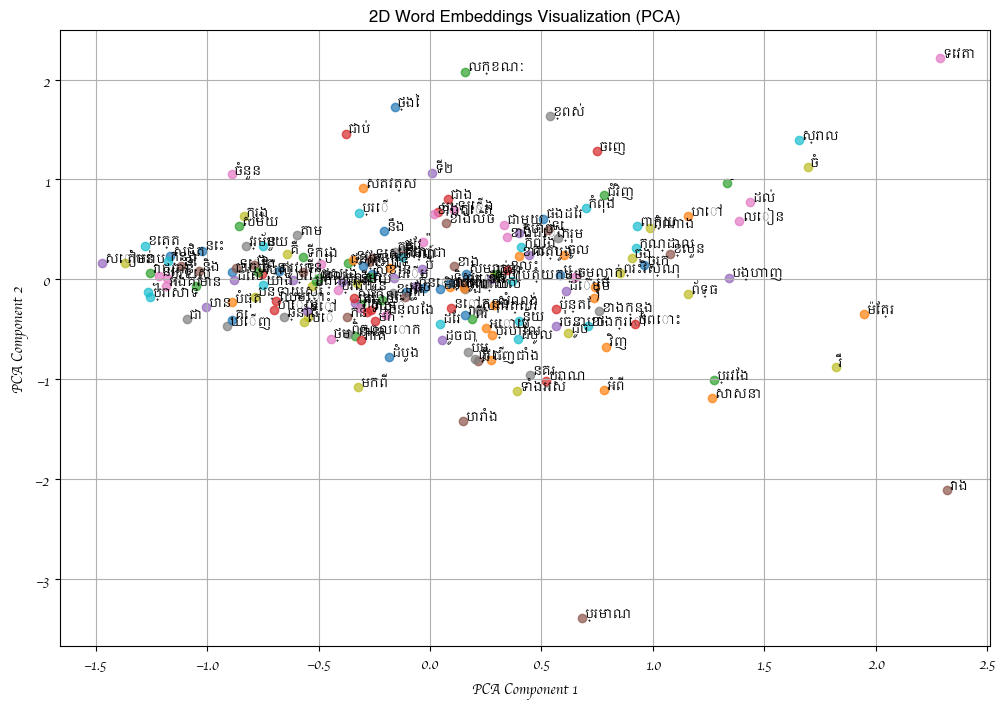

In [119]:
path = './font/Khmer-Regular.ttf'
path1 = '/Users/rattanak/Library/Fonts/KhmerOS.ttf'
path3 = './font/BATTAMBANG-REGULAR.TTF'
path4 = './font/Khmer OS System Regular.ttf'
fontprop = fm.FontProperties(fname=path)
fe = fm.FontEntry(
    fname=path4,
    name='khmer-regular')
fm.fontManager.ttflist.insert(0, fe) # or append is fine
mpl.rcParams['font.family'] = fe.name # = 'your custom ttf font name'
plt.rcParams["font.family"] = "cursive"

hfont = {'fontname':'Helvetica'}
khfont = {'fontname': 'khmer-regular'}

# plt.rcParams['font.sans-serif'] = "Noto Sans Khmer"
# plt.rcParams['axes.unicode_minus'] = False  # Ensure Khmer symbols are displayed correctly


# Step 1: Load Word Embeddings
word_embeddings = np.load("khmer_word_embeddings.npy")  # Load embeddings
print("word embedding shape", word_embeddings.shape)
words = list(word_to_idx.keys())  # List of words corresponding to embeddings

# Step 2: Apply PCA for Dimensionality Reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(word_embeddings)

# Step 3: Plot 2D Word Representations
plt.figure(figsize=(12, 8))
# plt.title("២វិមាឌរវាងពាក្យ dddd")

for i, word in enumerate(words):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, alpha=0.7)
    plt.text(x + 0.01, y + 0.01, word, fontsize=9, **khfont)

plt.title("2D Word Embeddings Visualization (PCA)", **hfont)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()

### III. Build a neural language model

In [120]:
import re
# Build Vocabulary
"""
Count the frequency of each word.
Exclude words with a frequency less than 10.
Treat spaces as stop words and ignore them.
Create a dictionary mapping each word to a unique index.
"""
# Check if the string contains only alphanumeric characters
pattern = r"^[a-zA-Z0-9]+$"  # Matches a string with only letters and numbers
# print(re.search(pattern, text))

word_counts = Counter(tokens)
vocab = {word for word, count in word_counts.items() if count >= 10 and word != ' '}
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}
vocab_size = len(vocab)

In [121]:
# Create Dataset for N-Gram (N=5)
N = 5

def create_ngram_data(tokens, N, word_to_idx):
    data = []
    for i in range(len(tokens) - N):
        if all(word in word_to_idx for word in tokens[i:i+N+1]):
            input_seq = [word_to_idx[tokens[j]] for j in range(i, i + N)]
            target = word_to_idx[tokens[i + N]]
            data.append((input_seq, target))
    return data

data = create_ngram_data(tokens, N, word_to_idx)
print(data)

[([60, 126, 83, 96, 175], 98), ([126, 83, 96, 175, 98], 104), ([83, 96, 175, 98, 104], 175), ([96, 175, 98, 104, 175], 179), ([175, 98, 104, 175, 179], 104), ([98, 104, 175, 179, 104], 89), ([21, 171, 68, 51, 3], 35), ([171, 68, 51, 3, 35], 89), ([79, 130, 137, 79, 154], 126), ([51, 3, 138, 106, 89], 79), ([3, 138, 106, 89, 79], 128), ([43, 126, 22, 79, 79], 128), ([126, 22, 79, 79, 128], 10), ([19, 127, 68, 123, 180], 51), ([127, 68, 123, 180, 51], 33), ([154, 7, 158, 136, 6], 127), ([7, 158, 136, 6, 127], 164), ([158, 136, 6, 127, 164], 7), ([136, 6, 127, 164, 7], 154), ([6, 127, 164, 7, 154], 53), ([127, 164, 7, 154, 53], 152), ([164, 7, 154, 53, 152], 89), ([160, 28, 79, 126, 138], 106), ([28, 79, 126, 138, 106], 83), ([79, 126, 138, 106, 83], 54), ([126, 138, 106, 83, 54], 165), ([82, 29, 55, 137, 132], 154), ([29, 55, 137, 132, 154], 82), ([137, 63, 79, 103, 159], 166), ([63, 79, 103, 159, 166], 3), ([79, 103, 159, 166, 3], 179), ([103, 159, 166, 3, 179], 104), ([126, 63, 94, 33,

In [122]:
# Define Dataset and DataLoader
class NGramDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target = self.data[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)

dataset = NGramDataset(data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Define Neural Language Model
class NeuralLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(NeuralLanguageModel, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(embedding_dim * N, hidden_size)  # Concatenate embeddings
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, vocab_size)  # Output layer

    def forward(self, x):
        embeddings = self.embeddings(x)  # Shape: (batch_size, N, embedding_dim)
        embeddings = embeddings.view(embeddings.size(0), -1)  # Flatten (batch_size, N * embedding_dim)
        hidden = self.fc1(embeddings)
        hidden = self.relu(hidden)
        output = self.fc2(hidden)  # Shape: (batch_size, vocab_size)
        # return output
        # add softmax
        return torch.softmax(output, dim=1) # Apply softmax activation

embedding_dim = 50
hidden_size = 512
model = NeuralLanguageModel(vocab_size, embedding_dim, hidden_size)

# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 6: Train the Model
num_epochs = 10
for epoch in range(num_epochs):
    total_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(dataloader):.4f}")
    # Compute Perplexity (PPL)
    avg_loss = total_loss / len(dataloader)
    perplexity = math.exp(avg_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")


Epoch 1/10, Loss: 5.2035, Perplexity: 181.9137
Epoch 2/10, Loss: 5.1943, Perplexity: 180.2423
Epoch 3/10, Loss: 5.1784, Perplexity: 177.4027
Epoch 4/10, Loss: 5.1352, Perplexity: 169.9047
Epoch 5/10, Loss: 5.0776, Perplexity: 160.3944
Epoch 6/10, Loss: 4.9872, Perplexity: 146.5200
Epoch 7/10, Loss: 4.8926, Perplexity: 133.3012
Epoch 8/10, Loss: 4.8443, Perplexity: 127.0156
Epoch 9/10, Loss: 4.7633, Perplexity: 117.1264
Epoch 10/10, Loss: 4.6513, Perplexity: 104.7208


In [123]:
# Measure model accuracy
def evaluate_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = model(inputs)
            predicted = torch.argmax(outputs, dim=1)  # Get the most probable word
            correct += (predicted == targets).sum().item()
            total += targets.size(0)

    accuracy = correct / total * 100
    return accuracy

# Compute Accuracy
accuracy = evaluate_accuracy(model, dataloader)
print(f"Model Accuracy: {accuracy:.2f}%")


Model Accuracy: 72.12%


In [135]:
# Test the Model
def predict_next_word(model, input_words):
    # print("input index: ", input_words)
    model.eval()
    with torch.no_grad():
        index_words = []
        for word in input_words:
            print(word_to_idx.get(word))
            if not word_to_idx.get(word):
                print("There is no word in database or invalid input")
                return
            
            index_words.append(word_to_idx.get(word))
            #   word_to_idx[word]
        input_idxs = torch.tensor(index_words, dtype=torch.long).unsqueeze(0)
        print("input index: ", input_idxs)
    
        # Get the word with the highest probability
        output = model(input_idxs)
        probabilities = output.squeeze(0)  # Remove batch dimension
        # predicted_idx = torch.argmax(output, dim=1).item()
        predicted_idx = torch.argmax(probabilities).item()
        return idx_to_word[predicted_idx]
    
# Example Prediction
# input_words = "ប្រាសាទអង្គរវត្តគឺតំណាងឲ្យ"
input_words = "ប្រាសាទនេះគឺជាផ្នែកនៃ"
# input_words = "ស្របតាមលក្ខណៈភូមិសាស្ត្រនៃ"
input_word_token = word_tokenize(input_words)
print(input_word_token)
next_word = predict_next_word(model, input_word_token)
print("Predicted next word:", next_word)

['ប្រាសាទ', 'នេះ', 'គឺជា', 'ផ្នែក', 'នៃ']
79
130
23
2
175
input index:  tensor([[ 79, 130,  23,   2, 175]])
Predicted next word: ភ្នំ


### IV. Modify the natural language model in III

In [125]:
# Build Vocabulary
word_counts = Counter(tokens)
vocab = {word for word, count in word_counts.items() if count >= 10 and word != ' '} # change count >= 2
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

vocab_size = len(vocab)
print("vocab size:", vocab_size)

# Step 2: Create Dataset for N-Gram (N=5)
N = 5

def create_ngram_data(tokens, N, word_to_idx):
    data = []
    for i in range(len(tokens) - N):
        if all(word in word_to_idx for word in tokens[i:i+N+1]):
            input_seq = [word_to_idx[tokens[j]] for j in range(i, i + N)]
            target = word_to_idx[tokens[i + N]]
            data.append((input_seq, target))
    return data

data = create_ngram_data(tokens, N, word_to_idx)

vocab size: 182


In [130]:
class NGramDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_seq, target = self.data[idx]
        return torch.tensor(input_seq, dtype=torch.long), torch.tensor(target, dtype=torch.long)


dataset = NGramDataset(data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
# Split into Train and Test sets
# train_size = int(0.8 * len(dataset))
# test_size = len(dataset) - train_size
# train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


class NeuralLanguageModelModified(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size):
        super(NeuralLanguageModelModified, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)  # Learnable embeddings
        self.fc1 = nn.Linear(embedding_dim * N, hidden_size)  # First hidden layer
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization
        self.norm1 = nn.LayerNorm(hidden_size)  # Layer normalization
        self.fc2 = nn.Linear(hidden_size, hidden_size // 2)  # Second hidden layer (added)
        self.norm2 = nn.LayerNorm(hidden_size // 2)
        self.fc3 = nn.Linear(hidden_size // 2, vocab_size)  # Output layer

    def forward(self, x):
        embeddings = self.embeddings(x)
        embeddings = embeddings.view(embeddings.size(0), -1)
        hidden = self.relu(self.fc1(embeddings))
        hidden = self.norm1(hidden)
        hidden = self.dropout(hidden)
        hidden = self.relu(self.fc2(hidden))
        hidden = self.norm2(hidden)
        output = self.fc3(hidden)
        return torch.softmax(output, dim=1)

embedding_dim = 50
hidden_size = 512
model_nlm_modified = NeuralLanguageModelModified(vocab_size, embedding_dim, hidden_size)

# Step 5: Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nlm_modified.parameters(), lr=0.001)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR after 5 epochs

# Step 6: Train the Model with Perplexity Calculation
num_epochs = 10  # Increased epochs
for epoch in range(num_epochs):
    model_nlm_modified.train()
    total_loss = 0
    for inputs, targets in dataloader:
        optimizer.zero_grad()
        outputs = model_nlm_modified(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # scheduler.step()  # Adjust learning rate

    avg_loss = total_loss / len(dataloader)
    perplexity = math.exp(avg_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}, Perplexity: {perplexity:.4f}")

# Save the trained model
MODEL_PATH = 'neural_language_model.pth'
torch.save(model_nlm_modified.state_dict(), MODEL_PATH)

def _evaluate_accuracy(_model, dataloader):
    _model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            outputs = _model(inputs)
            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    accuracy = correct / total * 100
    return accuracy

accuracy = _evaluate_accuracy(model_nlm_modified, dataloader)
print(f"Final Perplexity: {perplexity:.4f}")
print(f"Final Accuracy: {accuracy:.2f}%")

# Load the Model for Prediction
def load_model(model_path, vocab_size, embedding_dim, hidden_size):
    model = NeuralLanguageModelModified(vocab_size, embedding_dim, hidden_size)
    model.load_state_dict(torch.load(model_path, weights_only=False))
    model.eval()
    return model


Epoch 1/10, Loss: 5.2034, Perplexity: 181.8978
Epoch 2/10, Loss: 5.1739, Perplexity: 176.6012
Epoch 3/10, Loss: 5.1287, Perplexity: 168.7908
Epoch 4/10, Loss: 5.0292, Perplexity: 152.8134
Epoch 5/10, Loss: 4.9233, Perplexity: 137.4532
Epoch 6/10, Loss: 4.8338, Perplexity: 125.6890
Epoch 7/10, Loss: 4.7318, Perplexity: 113.5016
Epoch 8/10, Loss: 4.6249, Perplexity: 101.9896
Epoch 9/10, Loss: 4.5617, Perplexity: 95.7509
Epoch 10/10, Loss: 4.5022, Perplexity: 90.2150
Final Perplexity: 90.2150
Final Accuracy: 84.13%


In [134]:
def predict_next_word(_model, input_words):
    # print("input index: ", input_words)
    _model.eval()
    with torch.no_grad():
        index_words = []
        for word in input_words:
            print(word_to_idx.get(word))
            if not word_to_idx.get(word):
                print("There is no word in database or invalid input")
                return
            
            index_words.append(word_to_idx.get(word))
            #   word_to_idx[word]
        input_idxs = torch.tensor(index_words, dtype=torch.long).unsqueeze(0)
        print("input index: ", input_idxs)
    
        # Get the word with the highest probability
        output = _model(input_idxs)
        probabilities = output.squeeze(0)  # Remove batch dimension
        # predicted_idx = torch.argmax(output, dim=1).item()
        predicted_idx = torch.argmax(probabilities).item()
        return idx_to_word[predicted_idx]
# Example Prediction តំបន់

# Example Prediction
# loaded_model = load_model(MODEL_PATH, vocab_size, embedding_dim, hidden_size)
# input_words = "ប្រាសាទអង្គរវត្តគឺតំណាងឲ្យ"
input_words = "ប្រាសាទនេះគឺជាផ្នែកនៃ"
# input_words = "ស្របតាមលក្ខណៈភូមិសាស្ត្រនៃ"
input_word_token = word_tokenize(input_words)
print(input_word_token)
next_word = predict_next_word(model_nlm_modified, input_word_token)
print("Predicted next word:", next_word)

['ប្រាសាទ', 'នេះ', 'គឺជា', 'ផ្នែក', 'នៃ']
79
130
23
2
175
input index:  tensor([[ 79, 130,  23,   2, 175]])
Predicted next word: ភ្នំ


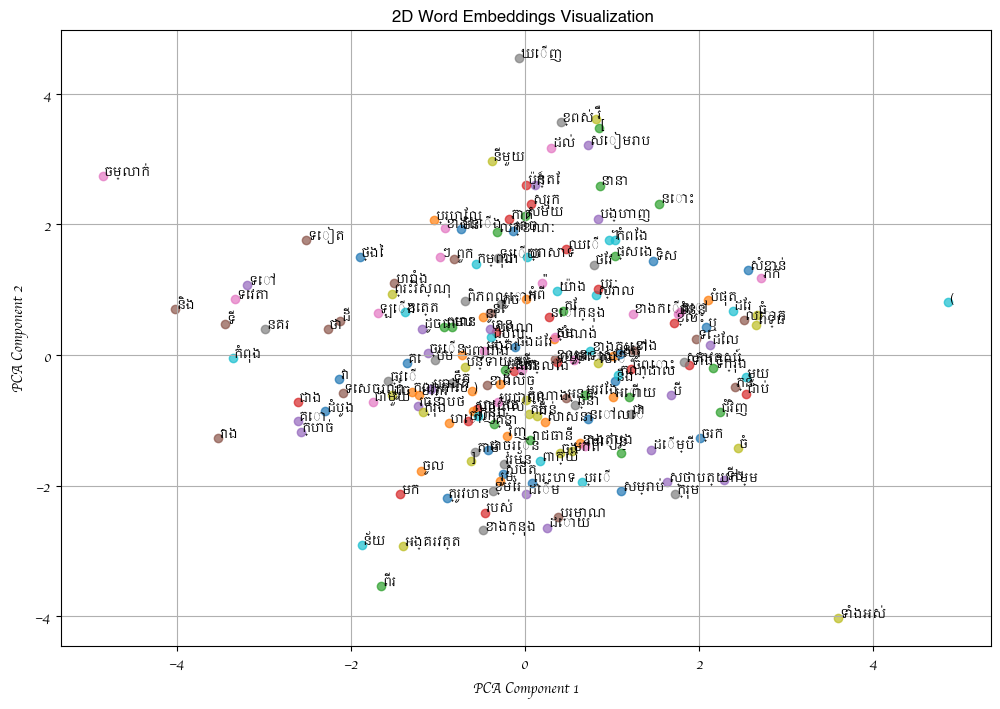

In [128]:
# Extract and Apply PCA to the Trained Embeddings
trained_embeddings = model_nlm_modified.embeddings.weight.data.numpy()

# Apply PCA for Dimensionality Reduction
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(trained_embeddings)

# Plot Word Representations in 2D
plt.figure(figsize=(12, 8))

for i, word in enumerate(word_to_idx.keys()):
    x, y = reduced_embeddings[i]
    plt.scatter(x, y, alpha=0.7)
    plt.text(x + 0.01, y + 0.01, word, fontsize=9, **khfont)

plt.title("2D Word Embeddings Visualization ", **hfont)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.grid(True)
plt.show()